In [1]:
!nvidia-smi

Thu May  6 06:55:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import necessary liberaries




In [2]:
!pip install tokenizers transformers -q

     |████████████████████████████████| 3.3MB 2.8MB/s 
     |████████████████████████████████| 2.1MB 16.9MB/s 
     |████████████████████████████████| 901kB 16.7MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split
from skimage.io import imread_collection,imread

from nltk.translate.bleu_score import sentence_bleu

from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img
from tensorflow.keras.applications import mobilenet_v2,mobilenet_v3
from tensorflow.keras import applications

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)


# Import data for training

In [5]:
!gsutil cp gs://semloh_bucket1/meme_for_train_resize.zip ./
!gsutil cp gs://semloh_bucket1/df_train.parquet.gzip ./
!gsutil cp gs://semloh_bucket1/df_val.parquet.gzip ./
!gsutil cp gs://semloh_bucket1/df_test.parquet.gzip ./

!unzip -q meme_for_train_resize.zip

Copying gs://semloh_bucket1/meme_for_train_resize.zip...
\ [1 files][806.6 MiB/806.6 MiB]   75.3 MiB/s                                   
Operation completed over 1 objects/806.6 MiB.                                    
Copying gs://semloh_bucket1/df_train.parquet.gzip...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      
Copying gs://semloh_bucket1/df_val.parquet.gzip...
/ [1 files][160.4 KiB/160.4 KiB]                                                
Operation completed over 1 objects/160.4 KiB.                                    
Copying gs://semloh_bucket1/df_test.parquet.gzip...
/ [1 files][ 62.4 KiB/ 62.4 KiB]                                                
Operation completed over 1 objects/62.4 KiB.                                     


In [6]:
df_train = pd.read_parquet('df_train.parquet.gzip')
df_val = pd.read_parquet('df_val.parquet.gzip')
df_test = pd.read_parquet('df_test.parquet.gzip')

In [7]:
MAX_SEQ_LEN =  len(df_train['CaptionText'][0])

# Utility Function


*   Transformer Block
*   DataGenerator



In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, x_col_tup, y_tup,target_size=(125,125) ,batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.target_size=target_size
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.x_col_tup = x_col_tup
        self.y_tup = y_tup
        self.on_epoch_end()
 
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))
 
    def __getitem__(self, ix):
      try:
        ix = self.index[ix * self.batch_size:(ix + 1) * self.batch_size]
      except:
        ix = self.index[(ix * self.batch_size)[0]:((ix + 1) * self.batch_size)[0]]
      j=[i for i in ix if i<len(self.indices)]
      batch = [self.indices[k] for k in j]
      X,y=self.__get_data(batch)
      return X, y
 
    def __randget__(self, ix):
      np.random.shuffle(self.index)
      np.random.shuffle(self.index)
      try:
        ix = self.index[ix * self.batch_size:(ix + 1) * self.batch_size]
      except:
        ix = self.index[(ix * self.batch_size)[0]:((ix + 1) * self.batch_size)[0]]
      j=[i for i in ix if i<len(self.indices)]
      batch = [self.indices[k] for k in j]
      X,y=self.__get_data(batch)
      return X, y
 
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)
 
    def __get_data(self, batch):
        batch_df=self.df.iloc[batch]
        
        X = []
        for i in self.x_col_tup:
            x_col,x_type=i
            x_dat=batch_df[x_col].values
            if (x_type=="img"):
                x_dat=np.array(imread_collection(x_dat.tolist()))
                X.append(x_dat)
            elif (x_type=="raw"):
                X.append(np.array(x_dat.tolist()))
            else:
                X.append(x_dat)
        y_col, y_type = self.y_tup
        y_dat=batch_df[y_col]
        y = np.array(y_dat.values.tolist())
        
 
        return X, y
 
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
          yield item

# Baseline

In [10]:
!gsutil cp gs://semloh_bucket1/baseline.h5 ./

Copying gs://semloh_bucket1/baseline.h5...
- [1 files][ 36.9 MiB/ 36.9 MiB]                                                
Operation completed over 1 objects/36.9 MiB.                                     


In [11]:
def get_baseline_model(text_emb_size = 512):

  eff_model = applications.EfficientNetB1(include_top=False, weights='imagenet')
  eff_model.trainable = True
  #img
  img_input = layers.Input(shape=(224,224,3,))
  img_emb = eff_model(img_input)
  img_emb = layers.GlobalAveragePooling2D()(img_emb)
  img_emb = layers.Dense(text_emb_size,activation='relu')(img_emb)
  img_emb = layers.Reshape((1,text_emb_size))(img_emb)
  #text
  text_input = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32)
  text_emb = layers.Embedding(tokenizer.get_vocab_size(), text_emb_size, input_length=MAX_SEQ_LEN)(text_input)
  #text-img
  text_img = layers.Concatenate(axis=1)([img_emb,text_emb])
  hidden = layers.Bidirectional(layers.GRU(text_emb_size))(text_img)
  hidden = layers.Dropout(0.5)(hidden)
  output = layers.Dense(tokenizer.get_vocab_size(),activation='softmax')(hidden)

  baseline = keras.Model(inputs=[img_input,text_input],outputs=output)
  return baseline


In [12]:
baseline_batchSize = 64
train_data_gen_baseline = DataGenerator(df_train,
                               x_col_tup=[('HashId','img'),('CaptionText','raw')],
                               y_tup=('label','None'),
                               batch_size=baseline_batchSize)

val_data_gen_baseline = DataGenerator(df_val,
                             x_col_tup=[('HashId','img'),('CaptionText','raw')],
                             y_tup=('label','None'),
                             batch_size=baseline_batchSize)

27025408/27018416 [==============================] - 0s 0us/step
Epoch 1/1000
2738/2738 [==============================] - 1841s 662ms/step - loss: 4.8271 - accuracy: 0.2885 - val_loss: 5.0560 - val_accuracy: 0.3020
Epoch 2/1000
2738/2738 [==============================] - 1801s 658ms/step - loss: 4.6966 - accuracy: 0.3021 - val_loss: 5.0210 - val_accuracy: 0.3065
Epoch 3/1000
2738/2738 [==============================] - 1802s 658ms/step - loss: 4.5909 - accuracy: 0.3107 - val_loss: 5.0272 - val_accuracy: 0.3112
Epoch 4/1000
2738/2738 [==============================] - 1803s 658ms/step - loss: 4.4890 - accuracy: 0.3197 - val_loss: 5.0004 - val_accuracy: 0.3124
Epoch 5/1000
2738/2738 [==============================] - 1804s 659ms/step - loss: 4.4123 - accuracy: 0.3264 - val_loss: 5.0215 - val_accuracy: 0.3160
Epoch 6/1000
2738/2738 [==============================] - 1806s 659ms/step - loss: 4.3582 - accuracy: 0.3295 - val_loss: 4.9747 - val_accuracy: 0.3189
Epoch 7/1000
2738/2738 [=====

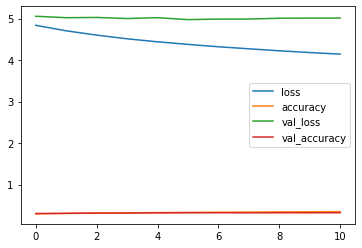

In [13]:
baseline = get_baseline_model(32)
baseline.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                 loss = "sparse_categorical_crossentropy",
                 metrics= "accuracy")

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,restore_best_weights=True)
history_baseline = baseline.fit(train_data_gen_baseline,
                                validation_data=val_data_gen_baseline,
                                epochs=1000,
                                verbose=1,
                                callbacks=[earlyStop])
pd.DataFrame(history_baseline.history).plot()

In [14]:
baseline.save_weights('baseline.h5')

In [15]:
!gcloud auth login
!gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=qZLar2WlnOYdlwQnPTWWIOgwCHl4qK&prompt=consent&access_type=offline&code_challenge=HvzQsFORsIZiKMB3HwEi0NyFNBJ3bRLkU63OLI8X6V4&code_challenge_method=S256

Enter verification code: 4/1AY0e-g41O6c57Ql94A07SJ8VfyvUMFOXPArZmZpvAbhEr5tU09n-pEnC_Cs

You are now logged in as [6133735923@student.chula.ac.th].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey

Go to the following 

In [16]:
!gsutil cp 'baseline.h5' gs://semloh_bucket1/

Copying file://baseline.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/36.9 MiB.                                     


# Model

In [10]:
eff_model = applications.EfficientNetB0(include_top=False, weights='imagenet')
bert_encoder = TFBertModel.from_pretrained("bert-base-uncased")
eff_model.trainable = True
bert_encoder.trainable = True

dropout_rate = 0.1
batchSize = 64
lr = 1e-5


#### IMG
img_input = layers.Input(shape=(224,224,3,),name='img_input')
img_emb = eff_model(img_input)
img_emb = layers.GlobalAveragePooling2D()(img_emb)

#### TEXT 
text_input = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name='text_input')
text_attention_input = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name='text_attention_input')
text_emb = bert_encoder(text_input, attention_mask=text_attention_input)[1] # 1 is for [cls] token

#### Combine text with img
img_word_emb = layers.Concatenate()([img_emb,text_emb])
img_word_emb = layers.Dropout(dropout_rate)(img_word_emb)

#### OUTPUT
output = layers.Dense(tokenizer.get_vocab_size(),activation='softmax')(img_word_emb)

model = keras.Model(inputs=[img_input,text_input,text_attention_input], outputs=output)
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
              loss = "sparse_categorical_crossentropy",
              metrics= "accuracy")
model.summary()

16711680/16705208 [==============================] - 0s 0us/step


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

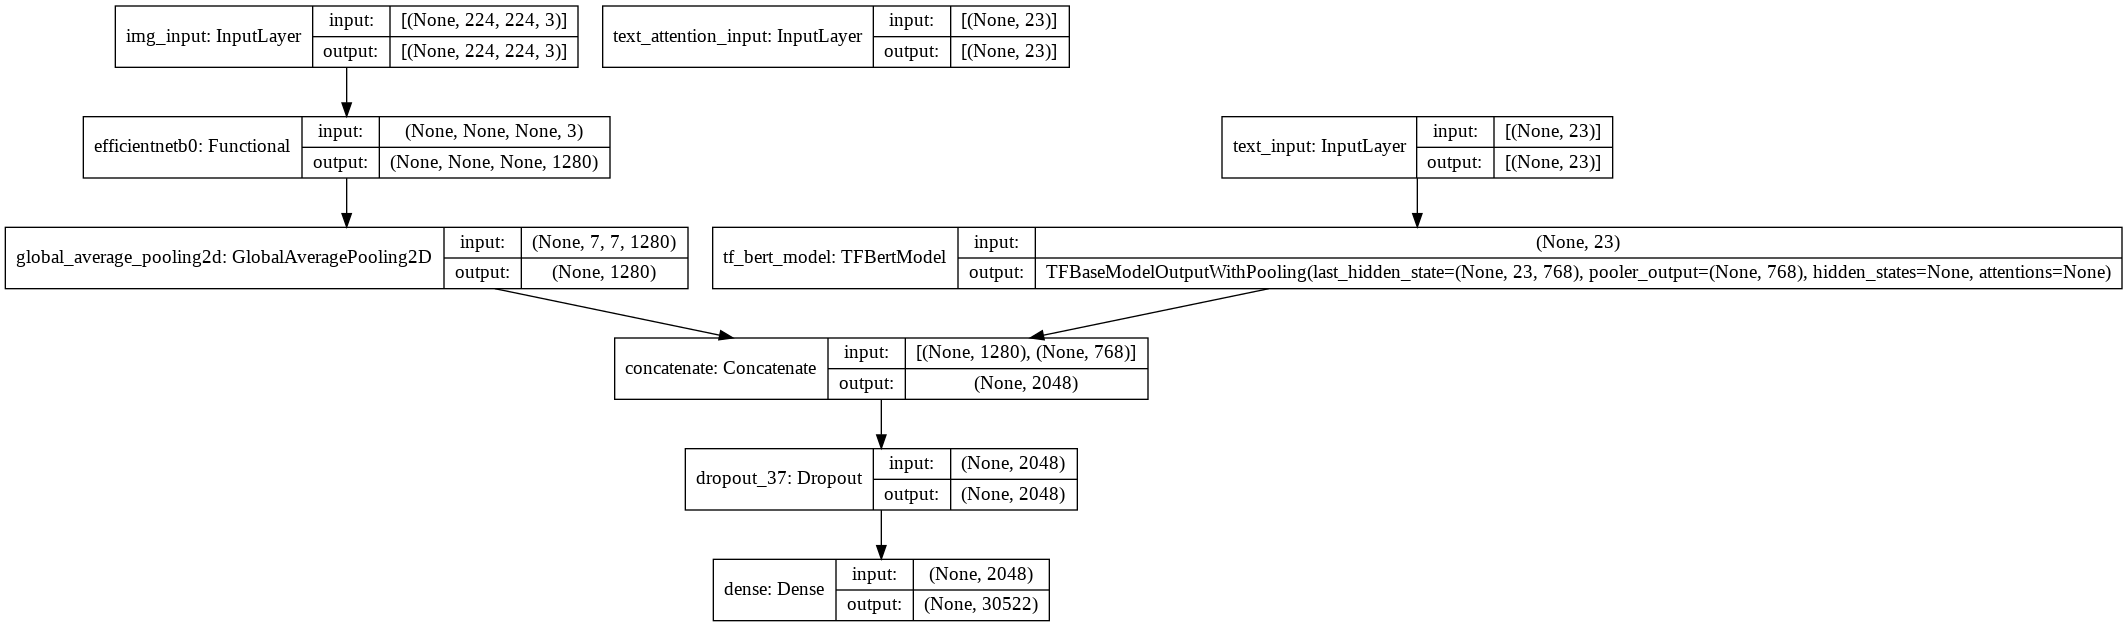

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
train_data_gen = DataGenerator(df_train,
                               x_col_tup = [('HashId','img'),('CaptionText','raw'),('attentionMask','raw')],
                               y_tup = ('label','None'),
                               batch_size = batchSize)

val_data_gen = DataGenerator(df_val,
                             x_col_tup = [('HashId','img'),('CaptionText','raw'),('attentionMask','raw')],
                             y_tup = ('label','None'),
                             batch_size = batchSize)

In [39]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3,restore_best_weights=True)
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=1000,
                    verbose=1,
                    callbacks=[earlyStop])
pd.DataFrame(history.history).plot()

In [ ]:
model.save_weights('model_b0_dropout10.h5')

# Evaluation

In [14]:
!gsutil cp gs://semloh_bucket1/model_b0_dropout10.h5 ./

model.load_weights('model_b0_dropout10.h5')

Copying gs://semloh_bucket1/model_b0_dropout10.h5...
| [1 files][672.2 MiB/672.2 MiB]                                                
Operation completed over 1 objects/672.2 MiB.                                    


In [18]:
# code from https://nbviewer.jupyter.org/github/Moeinh77/Image-Captioning-with-Beam-Search/blob/master/mainv3.ipynb
def beam_search_pred(model, pic_id, K_beams = 3, log = False):
    start = [101]
    start_word = [[start, 0.0]]
    img = np.array(imread_collection(pic_id))
    for _ in range(MAX_SEQ_LEN):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=MAX_SEQ_LEN,padding='post').reshape((1,MAX_SEQ_LEN))
            attn = np.array([[1]*len(s[0]) + [0] * (MAX_SEQ_LEN-len(s[0]))])
            preds = model.predict([img, sequence,attn])
            # preds = model.predict([img, sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] 

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = tokenizer.decode(start_word)
    return captions_

In [19]:
val_sample = df_val.loc[df_val['label']==102].sample(n=100)
val_sample_img = val_sample['HashId'].values.tolist()
val_sample_label = val_sample['CaptionText'].values.tolist()

for idx,seq in enumerate(val_sample_label):
  seq = seq.tolist()
  zero_idx = seq.index(0)
  seq[zero_idx] = 102
  val_sample_label[idx] = tokenizer.decode(seq)


In [20]:
beam_search_text_caption_val = []
for img in tqdm(val_sample_img):
  beam_search_text_caption_val.append(beam_search_pred(model,img,K_beams=5))

In [21]:
bleu_score_val = []
for y_pred,y_true in zip(beam_search_text_caption_val,val_sample_label):
  bleu_score_val.append(sentence_bleu([y_true],y_pred))
# print(np.mean(bleu_score_val))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [27]:
df_test_sample = df_test.sample(n=100)
df_test_text = [tokenizer.decode(i) for i in df_test_sample['CaptionText'].values]
df_test_img = df_test_sample['HashId']

beam_search_text_caption_test = []
for img in tqdm(df_test_img):
  beam_search_text_caption_test.append(beam_search_pred(baseline,img,K_beams=5))

In [28]:
bleu_score_test = []
for y_pred,y_true in zip(beam_search_text_caption_test,df_test_text):
  bleu_score_test.append(sentence_bleu([y_true],y_pred))
print(np.mean(bleu_score_test))

0.17679557354283773


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
